# Welcome to **Opening Advisor** for lichess.org!
## Opening Advisor is based on my previous project: **Chess MBTI**.
## It is designed to advice the best suiting openings based on your chess MBTI and in-game statistics.
## This notebook will cover all theoretical and technical details of how I approached and designed the project.
## Let's get started!

## First of all, let's install and import all of the necessary libraries. I'll cover their usage and purpose one by one.
- Berserk allows us to connect to lichess and extract the data.
- Pandas contains dataframes (matrices) and series (lists) objects that are much easier to work with than usual Python lists and have their own functions and modules which we'll use.
- Matplotlib is an essential library for visualizing.
- Scikit-learn is an ML library which contains a multitude of useful things ranging from data scaling tools to full-on models.
- xgboost has special XGB-models which are effective because they're calibrated to learn from previous iteration's mistakes and improve in that fashion.
- Numpy is a critical library for each data scientist, it contains more effective data structures and lots of mathematical functions.
- Scipy is almost like a more scientific extension of Numpy. In this project it won't be used a lot, but it does have amazing features inside.
- Tensorflow is great for advanced model development. Even more so because it contains a subunit called Keras, which can even be used to train neural networks, build autoencoders, etc.
- SHAP allows us to look inside of a black box, which is the model, and understand the logic and reasoning for it's outputs.
- Finally, joblib allows us to import models from file to file. We'll use it to implement models from our Chess MBTI project from earlier.

In [45]:
!pip install berserk
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost
!pip install numpy
!pip install scipy
!pip install tensorflow
!pip install shap
!pip install joblib

In [144]:
import berserk
import joblib
import scipy
import pandas as pd
import shap
import xgboost
import xgboost as xgb
import numpy as np
import warnings
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import CCA
from random import sample
from functions import get_data
from dotenv import load_dotenv
from tensorflow import keras
from keras.losses import Huber
from scipy.spatial import procrustes
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.callbacks import EarlyStopping
from keras import regularizers
warnings.filterwarnings('ignore')
shap.initjs()

## Now that the preliminary steps are donw, let's get down to business!
## Start by importing our chess opening database.

In [145]:
opening_table = pd.read_excel('OpeningList.xlsx')

## Next, let's separate the numerical statistics from the descriptory fields like name and piece color.
### There is a whole 19 columns on which the openings here were rated on a scale from 1 to 5. 
### Some of them are more understandable than others, so let me explain those that aren't.
- comp means complexity. Explains how difficult and unexplainable the theory or the ensuing middlegames are and how tough they are to navigate.
- imb means imbalance. Explains the extend to which the positions out of the opening are uncommon, whether in terms of material or positional criteria.
- tend means tendencies. Explains how likely you are to get to an endgame (endg_tend) or a tactical opportunity (tact_tend).
- adv_rat explains the average level at which you are most likely to see the opening.
- calc_necess explains whether you and your opponent will have to calculate your way out of the position or you can rely more on your intuition safely.
- setup_bsd explains how much the opening theory and middlegames rely on a specific setup, or each game will be a new adventure.
- engine_eval explains the objective engine evaluation of the opening.
- The rest of the metrics are more or less self-explanatory, so we won't look at them in depth.

## Last thing to mention here is that the dataset was composed manually and the ratings might not be objectively correct!

In [146]:
opening_table_stats = opening_table.loc[:, 'main_line_len':'adv_rat']
opening_table_stats

,main_line_len,theory_dens,theory_comp,opening_imb,calc_necess,intuit_score,pawn_str_stab,endg_tend,tact_tend,midgame_comp,midgame_imb,aggro_score,center_grip,king_sft,learn_crv,setup_bsd,engine_eval,surprise_val,adv_rat
0,2.0,2.5,2.0,1.5,2.5,4.5,4.5,2.0,2.0,2.0,2.0,1.5,2.0,4.5,2.0,4.0,2.5,4.5,3.0
1,2.0,2.5,2.5,1.0,2.5,4.5,4.0,3.0,3.0,2.5,2.5,2.0,3.0,4.0,1.5,4.5,1.5,3.0,1.5
2,3.0,3.0,3.0,2.0,3.0,3.5,2.5,4.0,1.5,2.0,2.5,1.5,2.0,4.5,2.5,3.5,2.5,3.0,2.0
3,3.5,3.5,3.5,2.5,3.0,3.0,3.0,2.5,2.5,3.0,3.0,2.5,3.5,4.0,3.0,3.0,3.0,2.5,2.5
4,2.5,2.5,3.0,2.0,2.5,3.5,3.5,3.0,2.5,3.0,2.5,2.5,3.0,4.0,2.5,3.5,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,4.0,4.0,3.5,3.5,4.0,3.0,2.5,3.0,3.0,3.0,3.5,3.0,3.0,4.0,4.0,3.5,3.5,4.0,4.0
138,3.0,4.5,3.5,4.0,4.0,3.5,3.5,2.5,3.5,3.5,3.5,3.5,3.5,4.0,4.0,3.5,2.5,4.5,3.5
139,3.0,3.0,3.0,3.5,3.0,3.5,3.5,2.5,4.0,3.0,3.5,4.5,4.0,3.5,3.0,3.5,1.5,3.5,2.5
140,3.5,2.5,3.0,3.5,3.0,3.5,3.0,3.0,3.0,3.0,3.5,3.0,3.5,4.0,3.0,3.0,2.0,2.5,3.0


### A rule to remember is wherever you got the dataset from, you must check it for NaN values, outliers, anything that can negatively impact the analysis!
### In this case, outliers shouldn't be a problem, since the data is scaled, but null values or duplicate values are still a thing, so be on a lookout.

In [147]:
print(opening_table_stats.isnull().sum().sum()) ## NaN amount value check.
print(opening_table_stats.duplicated().sum()) ## Duplicate rows check.
print(opening_table_stats.shape) ## Display the amount of rows, columns in a dataset.

0
0
(142, 19)


## As we see, there are no null values or duplicate rows. This means that we can begin the analysis.
## Let's start by renaming our table to X, which usually marks the main dataset.

In [148]:
X_init = opening_table_stats

## First thing we'll do is apply some called **PCA** to our dataset.
### PCA (or Principle Component Analysis) is used for a process called *dimension reduction*.
### In simple terms, we see that we have 19 metrics and we want to reduce this number **without losing the structure of our data**.
### PCA can help with that by taking our metrics and aggregating them.
### However, for interpretability's sake, we'll use differently - to see how much each metric contributes to our data's variety.

In [149]:
dim_red = PCA()
dim_red.fit(X_init) ## Feeding our data to a PCA model.
exp_var = dim_red.explained_variance_ratio_*100 ## exp_var will contain the percentage of each metric's contribution.
sum_var = 0 ## And sum_var will be used to sum all of them up.
for i in range(len(exp_var)):
    sum_var += exp_var[i] ## Update the sum_var with each metric.
    print(f'Explained variance for {i+1} metrics = {round(sum_var,2)}%')

Explained variance for 1 metrics = 49.73%
Explained variance for 2 metrics = 62.11%
Explained variance for 3 metrics = 71.39%
Explained variance for 4 metrics = 76.53%
Explained variance for 5 metrics = 81.27%
Explained variance for 6 metrics = 84.71%
Explained variance for 7 metrics = 87.14%
Explained variance for 8 metrics = 89.35%
Explained variance for 9 metrics = 91.22%
Explained variance for 10 metrics = 92.82%
Explained variance for 11 metrics = 94.02%
Explained variance for 12 metrics = 95.17%
Explained variance for 13 metrics = 96.15%
Explained variance for 14 metrics = 97.1%
Explained variance for 15 metrics = 97.77%
Explained variance for 16 metrics = 98.41%
Explained variance for 17 metrics = 99.02%
Explained variance for 18 metrics = 99.54%
Explained variance for 19 metrics = 100.0%


## So we see the cumulative contribution of a certain amount of metrics to the data variance.
### Remember, our main goal is to reduce metrics **without losing in data variance**.
### To my eyes, 9-11 metrics will hit that sweet spot of keeping 90-95% of variance while reducing our dataset by half!
### Unfortunately, we don't know namely which columns we should keep or remove, but we can create a **correlation matrix** to do that.
### Correlation matrix shows how much the metrics influence each other.

In [150]:
corr_matrix1=X_init.corr().abs() ## Display the influence value regardless whether it's positive or negative.
corr_matrix1.style.background_gradient(cmap='coolwarm') ## Changing the coloring to blue for small values and red for big values.

,main_line_len,theory_dens,theory_comp,opening_imb,calc_necess,intuit_score,pawn_str_stab,endg_tend,tact_tend,midgame_comp,midgame_imb,aggro_score,center_grip,king_sft,learn_crv,setup_bsd,engine_eval,surprise_val,adv_rat
main_line_len,1.000000,0.340624,0.461666,0.431142,0.493176,0.322537,0.229837,0.208983,0.393917,0.481255,0.446983,0.302760,0.108701,0.183880,0.532167,0.258920,0.385433,0.163619,0.455929
theory_dens,0.340624,1.000000,0.580897,0.354929,0.418645,0.364135,0.124242,0.299907,0.207726,0.393251,0.280482,0.175693,0.094809,0.071654,0.677295,0.206199,0.249066,0.123431,0.313793
theory_comp,0.461666,0.580897,1.000000,0.749305,0.813537,0.715462,0.564912,0.526122,0.650605,0.825298,0.742346,0.621433,0.129733,0.484428,0.842764,0.696429,0.016915,0.063501,0.379662
opening_imb,0.431142,0.354929,0.749305,1.000000,0.832394,0.626118,0.589269,0.580966,0.794612,0.812415,0.882152,0.797037,0.250642,0.562695,0.717222,0.629070,0.113679,0.150694,0.293717
calc_necess,0.493176,0.418645,0.813537,0.832394,1.000000,0.674773,0.622462,0.605982,0.759717,0.861146,0.831866,0.733877,0.225504,0.584455,0.789952,0.657439,0.023258,0.059936,0.345436
intuit_score,0.322537,0.364135,0.715462,0.626118,0.674773,1.000000,0.528480,0.484718,0.533820,0.655065,0.599664,0.493284,0.206606,0.376025,0.651584,0.681224,0.101534,0.121166,0.315803
pawn_str_stab,0.229837,0.124242,0.564912,0.589269,0.622462,0.528480,1.000000,0.387094,0.554755,0.596018,0.635984,0.560475,0.275897,0.450427,0.514240,0.590393,0.101883,0.121255,0.142217
endg_tend,0.208983,0.299907,0.526122,0.580966,0.605982,0.484718,0.387094,1.000000,0.556688,0.634995,0.594729,0.568232,0.269873,0.494137,0.514479,0.408266,0.167180,0.155460,0.115313
tact_tend,0.393917,0.207726,0.650605,0.794612,0.759717,0.533820,0.554755,0.556688,1.000000,0.789346,0.816911,0.856208,0.247504,0.607100,0.589035,0.512791,0.161492,0.060719,0.156816
midgame_comp,0.481255,0.393251,0.825298,0.812415,0.861146,0.655065,0.596018,0.634995,0.789346,1.000000,0.848613,0.766233,0.179745,0.603212,0.793715,0.648330,0.009294,0.059989,0.394182


## So here's an example of correlation matrix.
### You'll probably notice the red values going throughout the main diagonal.
### You can pretty much disregard it, because this shows metrics' influence on themselves, which is obviously 100%.
### Overall, although it's pretty, we almost can't make any certain conclusions from the matrix alone.
### So what we'll do is we'll calculate the average influence value for each row and we'll eliminate all metrics with influence value over 50%.

In [151]:
cols1 = list(corr_matrix1.columns) ## A list of all columns' names.
refined_feats = [] ## Metrics that weren't elimiated.
for i in cols1:
    corr_score = round(corr_matrix1[i].sum()/len(cols1),2) ## Calculate the average by dividing the cumulative influence value over metrics amount.
    if corr_score > 0.5: 
        print(corr_score, i) ## Output all elimiated metrics.
    else:
        refined_feats.append(i) ## Add all qualified metrics to the refined_feats list.

refined_feats.pop() ## In the end, I decided to remove the adv_rat metric, because although independent, it doesn't contribute or matter to the analysis.
len(refined_feats) ## Show how many metrics (features) are left.

0.57 theory_comp
0.59 opening_imb
0.6 calc_necess
0.54 tact_tend
0.6 midgame_comp
0.59 midgame_imb
0.53 aggro_score
0.57 learn_crv


10

## As we can see, 10 metrics is exactly what we aimed for here: we reduced our dataset almost by half and we still maintain 93% of our data's variety (according to PCA).
### Now we can reduce our initial X to the metrics that we just derived.

In [152]:
X = X_init[refined_feats] ## Now we can initialize our final version of the dataset - X.
X

,main_line_len,theory_dens,intuit_score,pawn_str_stab,endg_tend,center_grip,king_sft,setup_bsd,engine_eval,surprise_val
0,2.0,2.5,4.5,4.5,2.0,2.0,4.5,4.0,2.5,4.5
1,2.0,2.5,4.5,4.0,3.0,3.0,4.0,4.5,1.5,3.0
2,3.0,3.0,3.5,2.5,4.0,2.0,4.5,3.5,2.5,3.0
3,3.5,3.5,3.0,3.0,2.5,3.5,4.0,3.0,3.0,2.5
4,2.5,2.5,3.5,3.5,3.0,3.0,4.0,3.5,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...
137,4.0,4.0,3.0,2.5,3.0,3.0,4.0,3.5,3.5,4.0
138,3.0,4.5,3.5,3.5,2.5,3.5,4.0,3.5,2.5,4.5
139,3.0,3.0,3.5,3.5,2.5,4.0,3.5,3.5,1.5,3.5
140,3.5,2.5,3.5,3.0,3.0,3.5,4.0,3.0,2.0,2.5


## Now here comes the fun! 
## First of all, we'll allocate an MBTI to each opening as well.
### It might seem strange or overkill, but trust me, it will help us classify the openings tremendously.
### Let's quickly remind ourselves of the meaning of each Chess MBTI's letter.

### - Decision Making: U (Ultra-Calculator) / I (Instinctive) – describes the thought process behind player’s moves.
### - Position Handling: G (Grinder) / H (Hunter) – does the player capitalize on small, positional gains, or pounces on initiative?
### - Opening Approach: T (Theoretical) / N (Nonconformist) – does the player go with the flow in the opening, or studies them diligently?
### - Playing Style: L (Level-Headed) / V (Volatile) – mostly shaped by player’s middlegame approach: goes for calm/chaotic positions?

## This next step is also quite subjective, but let's try our best to map the features of the openings to the playing styles.
### For example, for the U/I debate, intuition value and the stability of the setup are definitely important. 
### For an instinctive player, it will also help if the opening is calmer, with more stable pawn structure and safer king.
### Therefore, the more of that there is in an opening, the better suited it is for an I-type. Let's keep it up for the other MBTI traits.

In [153]:
DM_list = [] ## Initializing the lists that will store the trait scores for each opening.
PH_list = [] ## Essentially, each opening will be rated on how much it suits a certain type of player, whether a U or a G.
OA_list = []
PS_list = []
for i in range(X.shape[0]):
    record = X.iloc[i] ## record here is each row (opening) of our reduced X.
    ## Below we'll calculate the importance of each metric to each trait score and derive a certain score.
    ## Remember that the values are strictly subjective and were derived and calibrated by a chess amateur, not a GM (yet! xD).
    DM_score = round(-1.75*record['intuit_score']-record['pawn_str_stab']-1.15*record['center_grip']-1.25*record['king_sft']-record['setup_bsd'],3)
    PH_score = round(1.5*record['endg_tend']+1.35*record['king_sft']+1.15*record['pawn_str_stab']+1.25*record['center_grip']-record['surprise_val'], 3)
    OA_score = round(1.75*record['theory_dens']+0.5*record['engine_eval']-1.5*record['surprise_val']-1.25*record['intuit_score']-1.15*record['setup_bsd'],3)
    PS_score = round(1.15*record['pawn_str_stab']+1.5*record['king_sft']+1.25*record['center_grip']+record['endg_tend'],3)
    DM_list.append(DM_score)
    PH_list.append(PH_score)
    OA_list.append(OA_score)
    PS_list.append(PS_score)
DM_srs = pd.DataFrame(DM_list, columns = ['Value']) ## The importance of pandas DataFrames is revealed.
PH_srs = pd.DataFrame(PH_list, columns = ['Value']) ## You can't apply the functions that we'll apply below to a simple list.
OA_srs = pd.DataFrame(OA_list, columns = ['Value']) ## This is exactly why we spent 4 lines of code changing our datatype to a DataFrame.
PS_srs = pd.DataFrame(PS_list, columns = ['Value'])

## Now that we have each opening evaluated, let me talk you through the next step.
### As I said before, we will assign an MBTI to each of our openings. 
### We'll do this by comparing each score to a median in each score list and thereby allocating a letter.
### However, to make it more fair, we won't give the opening that got the biggest score and the one that comes just after the median the same letter.
### Instead, we'll compare the openings to more extreme values first (25th and 75th percentile). If it's less or more than that, it gets a capital letter (UGTL).
### If it's somewhere closer to the middle, it gets a small letter (ugtl). The further purpose will be revealed later on. Let's rate them!

In [154]:
OL = ['' for i in range(X.shape[0])] ## Initialize the MBTI list for the opening.
for i in range(X.shape[0]):
    if DM_list[i] >= float(DM_srs.quantile(q=0.75)): ## Let's go through the algorithm again. First thing we do - compare to the 75% percentile of the corresponding score list.
        OL[i]+='U' ## If the score's bigger than that, give the opening a capital letter.
    elif DM_list[i] <= float(DM_srs.quantile(q=0.25)): ## Same goes for the other side.
        OL[i]+='I'
    elif DM_list[i] >= float(DM_srs.quantile(q=0.5)): ## If it doesn't suit either, compare to the middle value.
        OL[i]+='u' ## And assign the lowercase letter depending on where the score landed.
    elif DM_list[i] < float(DM_srs.quantile(q=0.5)):
        OL[i]+='i'
    if PH_list[i] >= float(PH_srs.quantile(q=0.75)):
        OL[i]+='G'
    elif PH_list[i] <= float(PH_srs.quantile(q=0.25)):
        OL[i]+='H'
    elif PH_list[i] >= float(PH_srs.quantile(q=0.5)):
        OL[i]+='g'
    elif PH_list[i] < float(PH_srs.quantile(q=0.5)):
        OL[i]+='h'  
    if OA_list[i] >= float(OA_srs.quantile(q=0.75)):
        OL[i]+='T'
    elif PH_list[i] <= float(PH_srs.quantile(q=0.25)):
        OL[i]+='N'  
    elif OA_list[i] >= float(OA_srs.quantile(q=0.5)):
        OL[i]+='t'
    elif OA_list[i] < float(OA_srs.quantile(q=0.5)):
        OL[i]+='n'
    if PS_list[i] >= float(PS_srs.quantile(q=0.75)):
        OL[i]+='L'
    elif PS_list[i] <= float(PS_srs.quantile(q=0.25)):
        OL[i]+='V'
    elif PS_list[i] >= float(PS_srs.quantile(q=0.5)):
        OL[i]+='l'
    elif PS_list[i] < float(PS_srs.quantile(q=0.5)):
        OL[i]+='v'

## Alright, now we can finally learn what that was made for.
### Remember that the first elimiation round for the openings was the MBTI compatibility.
### Now we'll compare the player's MBTI with the openings' MBTIs and remove those that don't fit.
### But first we have to add the type list to our dataset as a column for comparison.

In [155]:
X = pd.concat([X, pd.Series(OL).rename('Type')], axis=1) ## Add the type list as a column of our X.
X = pd.concat([X, opening_table['name'].rename('Name')], axis=1) ## Same with the opening names.
X_analysis = pd.concat([X, opening_table[['W', 'B']]], axis=1) ## Create a copy for the future.

## Let's use ChessMBTI to extract the type.

In [62]:
nickname = str(input('Enter your nickname: '))

Enter your nickname:  RomKali


In [106]:
dataset, result_type, stage = get_data(nickname)
print(result_type)

UGTL


## And now we begin the elimiation process.
### To do that, we'll compare each MBTI letter of each opening to our player's MBTI.
### If they don't match at all, compatibility score doesn't update.
### If the opening's letter is capital and matches, compatibility score is updated by 1.
### However, if letters match but the opening's letter is lowercase, compatibiltiy score is update by 0.625.
### 0.625 might seem weird, but it's purpose is very simple: the qualification score is 2.5, 4*0.625 is exactly 2.5.
### If we lowered the qualification threshold to 2, then 2 strong matches would be enough, which is objectively not enough.
### By making it 0.625, opening needs at least 4 weak matches or 2 strong and 1 weak match.

In [107]:
choice_df = [] ## Initialize the qualification list.
for i in range(X.shape[0]):
    score=0
    for j in range(len(X.iloc[i]['Type'])):
        if X.iloc[i]['Type'][j] in result_type: ## Strong match check.
            score+=1 
        elif X.iloc[i]['Type'][j] in result_type.lower(): ## Weak match check.
            score+=0.625
    if score>=2.5: ## 1 will signal that opening qualified, 0 that it didn't.
        choice_df.append(1)
    else:
        choice_df.append(0)



In [108]:
X=pd.concat([X, pd.Series(choice_df).rename('Qualified')], axis=1) ## Finally, update our list with qualification column.
X=pd.concat([X, opening_table[['W', 'B']]], axis=1) ## Also, add the opening color as a column.
X

,main_line_len,theory_dens,intuit_score,pawn_str_stab,endg_tend,center_grip,king_sft,setup_bsd,engine_eval,surprise_val,Type,Name,Qualified,W,B
0,2.0,2.5,4.5,4.5,2.0,2.0,4.5,4.0,2.5,4.5,,4 Knights (Glek),0,1,0
1,2.0,2.5,4.5,4.0,3.0,3.0,4.0,4.5,1.5,3.0,,4 Knights (Italian),0,1,0
2,3.0,3.0,3.5,2.5,4.0,2.0,4.5,3.5,2.5,3.0,,4 Knights (Scotch),0,1,0
3,3.5,3.5,3.0,3.0,2.5,3.5,4.0,3.0,3.0,2.5,,4 Knights (Spanish),0,1,0
4,2.5,2.5,3.5,3.5,3.0,3.0,4.0,3.5,3.0,4.0,,4 Knights English (a3),0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,4.0,4.0,3.0,2.5,3.0,3.0,4.0,3.5,3.5,4.0,,Tarrasch Defense,0,0,1
138,3.0,4.5,3.5,3.5,2.5,3.5,4.0,3.5,2.5,4.5,,Trompowsky Attack,0,1,0
139,3.0,3.0,3.5,3.5,2.5,4.0,3.5,3.5,1.5,3.5,,Vienna Gambit,0,1,0
140,3.5,2.5,3.5,3.0,3.0,3.5,4.0,3.0,2.0,2.5,,Vienna Game (Falkbeer-Mieses),0,1,0


## Now the final data preparation step is left.
### First we will remove all eliminated openings.
### Then will divide our dataset into two: the white openings and black openings.

In [109]:
df=X[X['Qualified']==1] ## Remove all eliminated openings.

In [110]:
dfW = df[df['W']==1] ## Create a dataset of White openings.
dfB = df[df['B']==1] ## Create a dataset of Black openings.
dfW.drop(['Qualified', 'Type'], inplace=True, axis=1) ## Only leave the stats.
dfW=dfW.loc[:,'main_line_len':'Name']
dfB.drop(['Qualified', 'Type'], inplace=True, axis=1) ## Only leave the stats.
dfB=dfB.loc[:,'main_line_len':'Name']

## And that is the data preparation done!
### Next, these datasets will be used only after creating the models to determine the best suiting openings.
### Now let's move on to step 2: building a model which will pick out the best openings out of the qualified ones.
### This step is quite technical, so I'll do my best to explain it in simple terms.
### To begin, let's return to our initial dataset and only leave out the stats.

In [111]:
X.drop(columns=['Type', 'Name', 'Qualified', 'W','B'], inplace=True)
X

,main_line_len,theory_dens,intuit_score,pawn_str_stab,endg_tend,center_grip,king_sft,setup_bsd,engine_eval,surprise_val
0,2.0,2.5,4.5,4.5,2.0,2.0,4.5,4.0,2.5,4.5
1,2.0,2.5,4.5,4.0,3.0,3.0,4.0,4.5,1.5,3.0
2,3.0,3.0,3.5,2.5,4.0,2.0,4.5,3.5,2.5,3.0
3,3.5,3.5,3.0,3.0,2.5,3.5,4.0,3.0,3.0,2.5
4,2.5,2.5,3.5,3.5,3.0,3.0,4.0,3.5,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...
137,4.0,4.0,3.0,2.5,3.0,3.0,4.0,3.5,3.5,4.0
138,3.0,4.5,3.5,3.5,2.5,3.5,4.0,3.5,2.5,4.5
139,3.0,3.0,3.5,3.5,2.5,4.0,3.5,3.5,1.5,3.5
140,3.5,2.5,3.5,3.0,3.0,3.5,4.0,3.0,2.0,2.5


## Now let's see what we're working with.
### First thing that comes to mind: how can we work with opening dataset and user stats dataset? They're totally different!
### And that's exactly the right question. The solution for this project: **eutoencoders**.
### Autoencoders consist of two subunits: **encoders** and **decoders**.
### Simply speaking, autoencoders are trained to effectively capture the data that was 'squished' into a smaller amount of metrics.
### Encoder will do the squishing and then the decoder will take the reduced data and try to replicate it as accurately and close to original as possible.
### That's usually how it happens, but our goal is to only leave the encoder part and reduce our data to the same amount of metrics.
### Then, we will take those 'squished' datasets and apply some math to it to make them almost a part of the same dataset (mathematically).
### Finally, once it's done, we can directly compare them and find the closest match between an opening and a player's data.
## I know, I know, sounds hard and silly, but let's take it one step at a time and you'll see how easy it actually is!

In [112]:
Scaler1= MinMaxScaler() ## First, let's initialize something called a scaler. It will make our data uniform and will rate each entry and each metric from 0 to 1.
X1 = Scaler1.fit(X).transform(X) ## Now fit our data into the scaler.

In [113]:
MBTI_df = pd.read_csv('df1.csv') ## Now we do the scaling for player data. Begin by importing the player dataset.
MBTI_df.dropna(axis=0, inplace=True) ## Remove all of the rows with incorrect values.
cols2 = MBTI_df.columns ## Create a list with all of the columns, which we'll need in the future.
Scaler2= MinMaxScaler() ## Create the same scaler which will put our data on a uniform 0-1 scale.
X2 = Scaler2.fit(MBTI_df).transform(MBTI_df) ## Fit the data in.

## Now our data is uniformly scaled. 
### Let's divide it into training and testing datasets.
### In general, model does the calibrating using training dataset and will then use the testing set to check the accuracy.

In [114]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, [None for i in range(X1.shape[0])], test_size = 0.2, random_state=42) ## Divide the data 80/20.
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, [None for i in range(X2.shape[0])], test_size = 0.2, random_state=42) ## Training - 80, testing - 20.

## Now we are introduced to the tensorflow library.
### Tensorflow contains a module called Keras, which is used for more advanced model development and training.
### Keras can also be used to build autoencoders using **neural networks**.
### Simply put, neural network here is a connection of layers, each with it's specific function.
### As for autoencoders, these layers are designed to to the 'squishing' and bringing the data to the same dimension as before.
## Feel free to look at the code before, but **don't run it**!
### I've already trained and loaded the autoencoders using the code below and it takes a good couple of minutes.
### So save yourself some time and just run the code in the cell below that one to load the autoencoders.

In [25]:
opening_enc_in = keras.Input(shape=(10,)) ## Input layer reads the information. We must specify that there will be 10 metrics.
opening_enc_out=keras.layers.Dense(7, activation='elu')(opening_enc_in) ## Next, first stage of 'squishing' the data. Let's begin by lowering the metrics' amount to 7.
opening_enc_out=keras.layers.Dense(4, activation='elu')(opening_enc_out) ## And now to 4.
opening_enc = keras.Model(opening_enc_in, opening_enc_out) ## The data now is reduced to 4 metrics. Notice that they are not in their initial form, but rather a combination of initial ones.
opening_decod_in = keras.layers.Dense(7, activation='elu')(opening_enc_out) ## Now the decoder: the one that brings the data back. Begin by expanding the data to 7 metrics.
opening_decod_out = keras.layers.Dense(10, activation='elu')(opening_decod_in) ## Complete the transformation and return to 10 metrics.
opening_autoenc = keras.Model(inputs=opening_enc_in, outputs=opening_decod_out) ## That's autoencoder done - we reduced the 10 metrics to 4 and brought it back to 10 with slight losses.
opening_autoenc.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=Huber(delta=0.1)) ## Compile the autoencoder before fitting the data.
opening_autoenc.fit(X1_train, X1_train, epochs=1000,validation_split=0.2, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)) ## Fit the data in and it's done!

In [115]:
opening_autoenc=load_model('opening_autoenc.keras') ## Load the prepared autoencoder.
opening_enc=load_model('opening_enc.keras') ## And the encoder (just squishing mechanism) separately.
pred_1 = opening_autoenc.predict(X1_test) ## We will use autoencoder to measure the accuracy of the whole process.
Y1 = opening_enc.predict(X1) ## If it's satisfactory, we will use just the encoder then to reduce the data to 4 metrics.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


## Now we do the same for the user dataset.
### The only difference is that we start with 13 metrics rather than 10, so we add an extra step (13-10-7-4).
### Just as before: do **NOT** run the code below, just run the cell below that one to load the prepared autoencoder.

In [32]:
user_enc_in = keras.Input(shape=(13,))
user_enc_out=keras.layers.Dense(10, activation='elu')(user_enc_in)
user_enc_out=keras.layers.Dense(7, activation='elu')(user_enc_out)
user_enc_out=keras.layers.Dense(4, activation='elu')(user_enc_out)
user_enc = keras.Model(user_enc_in, user_enc_out)
user_decod_in = keras.layers.Dense(7, activation='elu')(user_enc_out)
user_decod_out=keras.layers.Dense(10, activation='elu')(user_decod_in)
user_decod_out = keras.layers.Dense(13, activation='elu')(user_decod_out)
user_autoenc = keras.Model(inputs=user_enc_in, outputs=user_decod_out)
user_autoenc.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),loss=Huber(delta=0.1))
user_autoenc.fit(X2_train, X2_train, epochs=1000,validation_split=0.2, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True))

In [116]:
user_enc=load_model('user_enc.keras')
user_autoenc=load_model('user_autoenc.keras')
pred_2 = user_enc.predict(X2_test)
Y2 = user_enc.predict(X2)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


## Now we have both datasets reduced to 4 metrics. Beautiful!
### Final confirmation test is the accuracy test: we'll check how much data is lost after autoencoder parses it.
### We'll also make a little detour to SHAP to check which initial metrics contributed to these 4 metrics.
### Remember that encoders don't just pick out 4 metrics and leave them unchanged. These 4 metrics are a combination of the initial ones in a different capacity.

In [117]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42) ## Make a training and testing set out of initial and encoded data.
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42) ## Once again, 80% for training set, 20% for testing set.

### To use SHAP, we have to train a model, where the input data X is the initial data and the target data Y is the encoded data.
### SHAP will then analyze the model and be able to 'translate' the logic of the model by telling us which metrics contributed the most.

In [118]:
opening_dimensions_models=[] ## Initialize the list for models.

for i in range(Y1_train.shape[1]):
    opening_model = xgb.XGBRegressor(booster= 'gbtree', dart_normalized_type= 'tree', gamma= 0, learning_rate= 0.5, n_estimators= 10, tree_method= 'exact') ## Initialize the model.
    mismatch=0 ## We'll also calculate the accuracy of the model.
    opening_model.fit(X1_train, Y1_train[:,i]) ## Fit the data in. Only this time, our X is the initial dataset and Y is a column of our reduced version of the data, because each column
    ## is like a vector, to which each initial metric contributed to some extent and want to check this extent.
    Y_hat = opening_model.predict(X1_test) ## Use the fitted model to predict this column's value for the testing set.
    opening_dimensions_models.append(opening_model) ## Add the model to the list.
    for j in range(Y_hat.shape[0]): ## Now let's check the accuracy.
        mismatch += abs(Y_hat[j]-Y1_test[j][i]) ## Mismatch, in this case, is the absolute difference between the prediction and the actual value of the reduced data column.
    accuracy = 100 - (mismatch/2/Y_hat.shape[0]*100) ## Now display the accuracy percentage wise: 100 - mismatch percentage.
    print(f'{round(accuracy, 2)}%')

95.97%
91.82%
96.33%
98.45%


## As we can see, the models show a great accuracy ranging from 91.8 to 98.4 percent!
### Keep in mind that our opening dataset is relatively small having only 142 entries, so it's surely a success.
### Now we will do the same for our user data, check the accuracies and finally apply SHAP to get 'under the hood' of our model's logic.

In [119]:
user_dimensions_models=[]

for i in range(Y2_train.shape[1]):
    mismatch=0
    user_model = xgb.XGBRegressor(booster= 'gbtree', dart_normalized_type= 'tree', gamma= 0, learning_rate= 0.5, n_estimators= 10, tree_method= 'exact')
    user_model.fit(X2_train, Y2_train[:,i])
    Y_hat = user_model.predict(X2_test)
    user_dimensions_models.append(user_model)
    for j in range(Y_hat.shape[0]):
        mismatch += abs(Y_hat[j]-Y2_test[j][i])
    accuracy = 100 - (mismatch/2/Y_hat.shape[0]*100) ## Now display the accuracy percentage wise: 100 - mismatch percentage.
    print(f'{round(accuracy, 2)}%')

99.34%
99.6%
98.53%
98.84%


## As expected, with the dataset size grows the accuracy, which is now 98-99%!
### Finally, the models are now prepped, so we can visualize the metric importance for all of our encoders.
### Feel free to look at the graphs and as an exercise, try to semantically match the opening model values to user data model values.

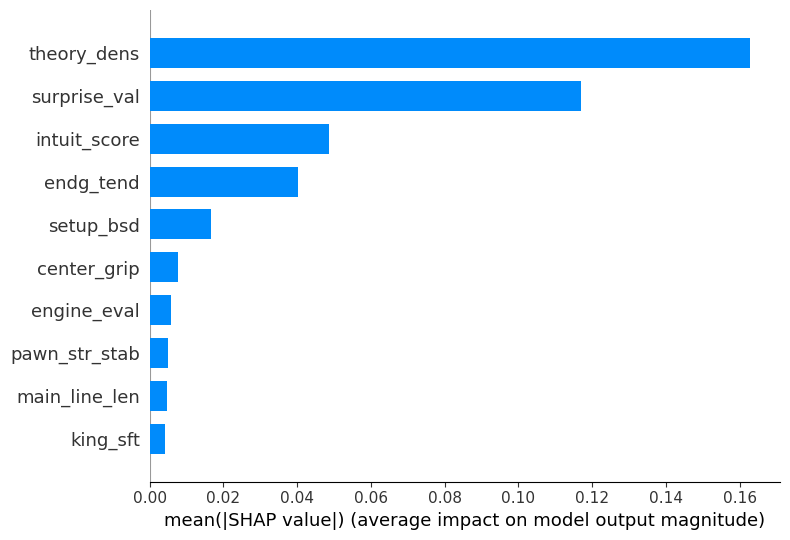

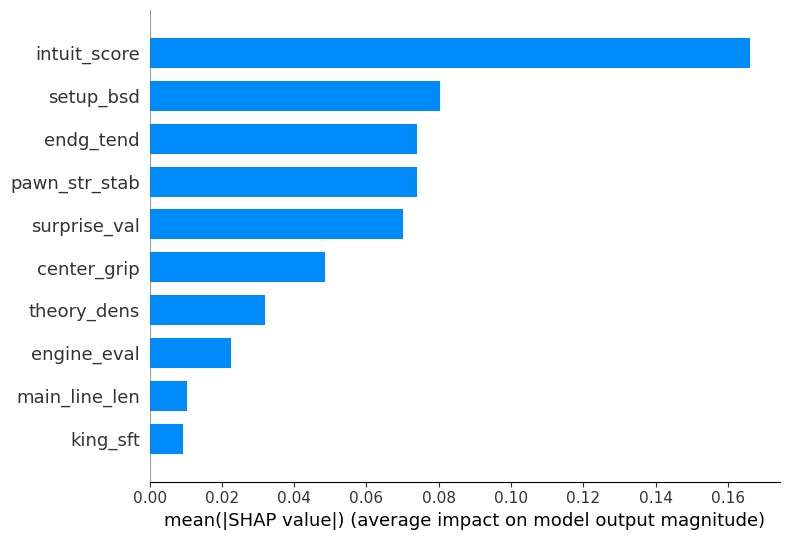

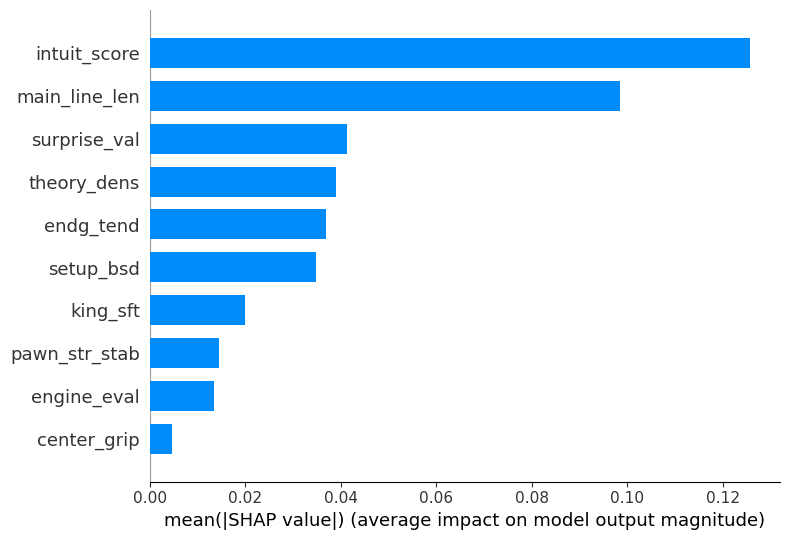

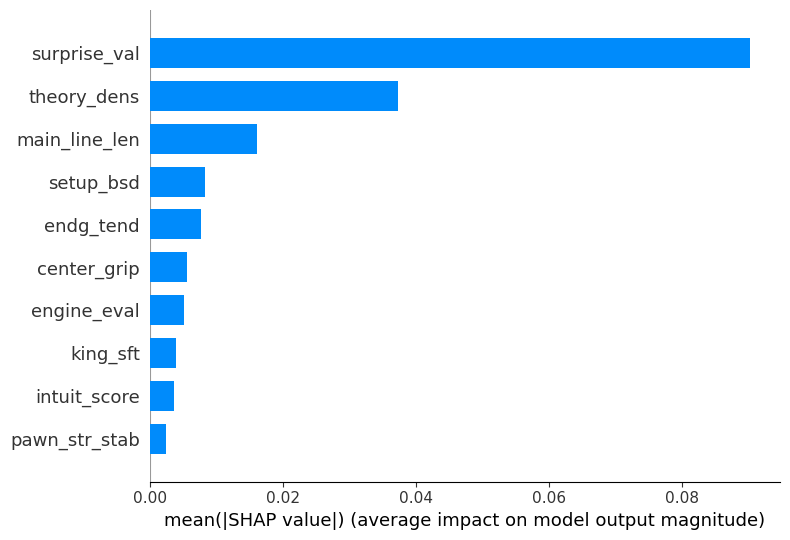

In [120]:
X1=pd.DataFrame(X1, columns=refined_feats)
for i in range(len(opening_dimensions_models)):
    explainer = shap.TreeExplainer(opening_dimensions_models[i])
    shap_values = explainer(X1)
    plt.show()
    shap.summary_plot(shap_values, X1, plot_type="bar")

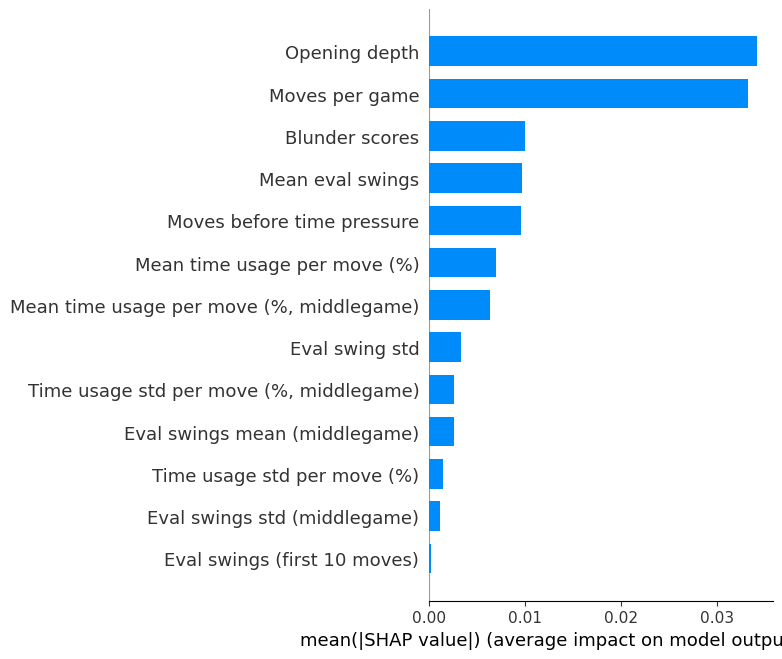

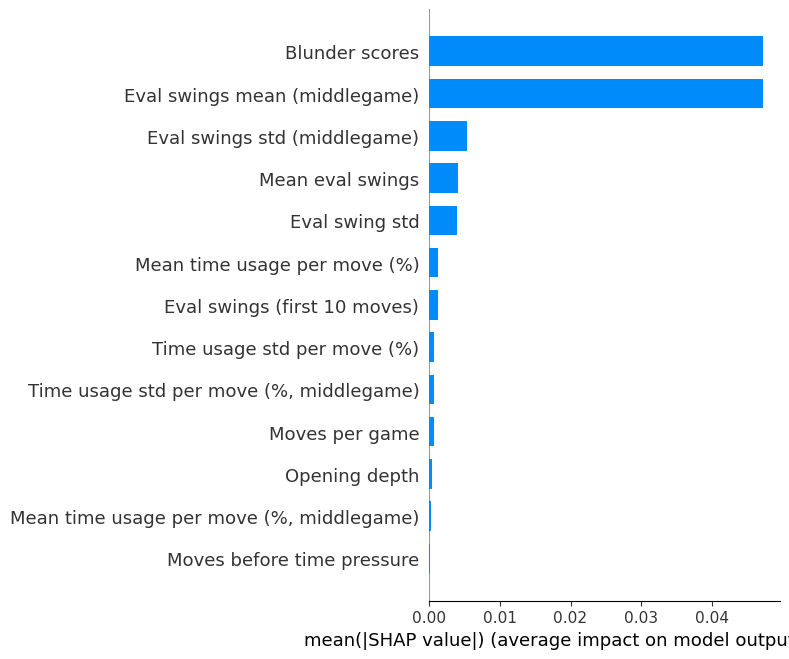

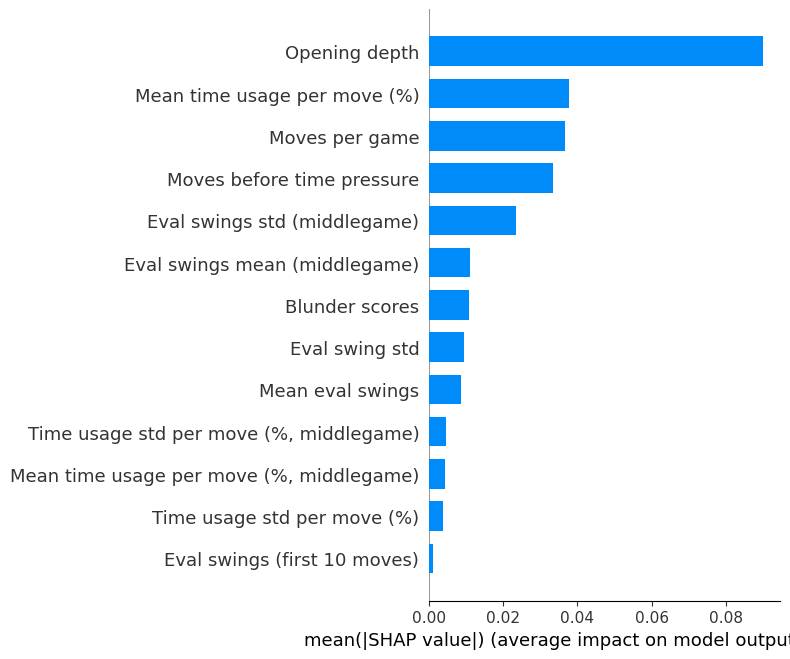

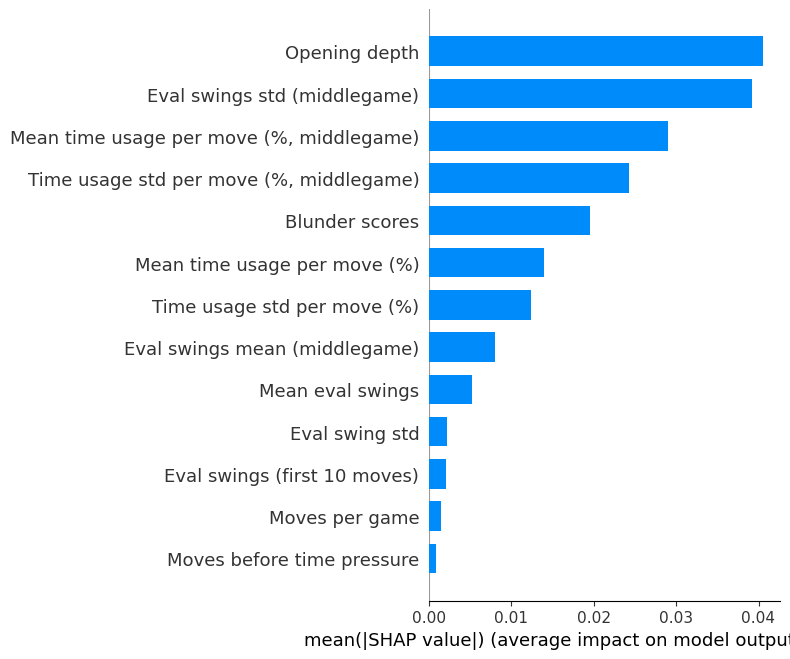

In [122]:
X2=pd.DataFrame(X2, columns=list(cols2))
for i in range(len(opening_dimensions_models)):
    explainer = shap.TreeExplainer(user_dimensions_models[i])
    shap_values = explainer(X2)
    plt.show()
    shap.summary_plot(shap_values, X2, plot_type="bar")

## Now we are in the closing stages of the project.
### With our now reduced data, we have to mathematically align it so that the data becomes directly comparable.
### But first, we need to prepare our data by making it the same size. Since there amount of metrics is the same, we only need to align the rows.

In [123]:
Y1 = pd.DataFrame(Y1) ## Change the type to DataFrame.
Y2 = pd.DataFrame(Y2) 
Y2_dummy, Y2, dummy1, dummy2 = train_test_split(Y2, [None for i in range(Y2.shape[0])], test_size = 994, random_state = 42) 
## In the line above, we used a little trick: use the train/test split function, but only use the testing set with specific amount of entries, which are picked out randomly. 
Y1_copy = Y1 ## Initialize the copy to use for duplication. 
while Y1.shape[0] < 994:
    Y1 = pd.concat([Y1, Y1_copy], axis=0) ## Duplicate the opening dataset until their row amount is the same.
print(Y1.shape==Y2.shape)

True


## Now it might seem a little strange what we did above, so let's go through the process again.
### Since we only needed to equalize the amount of rows, first thing that comes to mind is to either reduce the bigger set or duplicate the smaller set.
### The problem is the difference: opening set contains 142 rows, whereas the user dataset contains whooping 3324 rows!
### So the only viable options is to both reduce the user dataset and duplicate the opening dataset, because reducing 3324 to 124 or duplicating 124 until 3324 would have negatively impacted our analysis.
### By meeting in the middle, we were able to mitigate this effect.

## Now for the final step: mathematical alignment of reduced data.
### For this step we'll use a technique called **CCA** (**C**anonical **C**orrelation **A**nalysis).
### In essence, CCA takes two unrelated or weakly related datasets and aims to find the relationships between them.
### It does that by searching for the combinations of metrics that produce the most correlation.
### In the end, it transforms the initial datasets and installs them both in a very similar geometrical space, so that they're aligned.

In [124]:
aligner = CCA(n_components=4) ## Initialize the CCA.
Y1, Y2 = aligner.fit(Y1, Y2).transform(Y1,Y2) ## Fit the reduced datasets in CCA and apply the CCA to them.
opening_proj_values = aligner.x_weights_ ## X and Y weights contain the matrices that CCA derived.
user_proj_values = aligner.y_weights_ ## To apply CCA manually, you can use matrix multiplication of your data matrix and the one that CCA derived.

## Finally, we are done with the technical part!
### The data is now reduced and aligned, and now we are all set to find the opening-player pair that sits the closest in the newly created space.
### The opening that corresponds to the lowest distance to the player dataset vector is the one that (at least mathematically) suits him/her the most.
## All that's left to do now is to test it!
### Feel free to enter your nickname, launch the code and give it a go.
### To save your time, I reduced all of the technicalities to one function, which I strongly advice you to take a look at!
## Thank your for you attention, hope you'll enjoy the Opening Advisor for lichess.org! :)

In [92]:
username = str(input('Enter your nickname: '))
dataset, result_type, stage = get_data(username)
print(result_type)

Enter your nickname:  RomKali


UGTL


In [156]:
choice_df = []
for i in range(X_analysis.shape[0]):
    score=0
    for j in range(4):
        if X_analysis.iloc[i]['Type'][j] in result_type:
            score+=1
        elif X_analysis.iloc[i]['Type'][j] in result_type.lower():
            score+=0.625
    if score>=2.5:
        choice_df.append(1)
    else:
        choice_df.append(0)
X_analysis=pd.concat([X_analysis, pd.Series(choice_df).rename('Qualified')], axis=1)
df=X_analysis[X_analysis['Qualified']==1]
dfW = df[df['W']==1]
dfB = df[df['B']==1]
dfW.drop(['Qualified', 'Type'], inplace=True, axis=1)
dfW_names = dfW['Name']
dfW=dfW.loc[:,'main_line_len':'surprise_val']
dfB.drop(['Qualified', 'Type'], inplace=True, axis=1)
dfB_names = dfB['Name']
dfB=dfB.loc[:,'main_line_len':'surprise_val']

In [157]:
def UserPipeline(dataset, dfW, dfB): ## Shortened version of the technical aspects.
    cosW = [] ## We will use cosine distance to measure the alignment of user's data to opening data.
    cosB = [] ## As opposed to Euclidean distance, cosine distance cares more about the direction of data vectors, not the magnitude.
    ## So for example, vector [1, 1, 2] and [2, 2, 4] will be the same to cosine distance as they are just scaled version of each other.
    
    dfW = Scaler1.transform(dfW) ## Step 1: scale the opening data from 0 to 1.
    dfB = Scaler1.transform(dfB)
    dataset = Scaler2.transform(dataset) ## Step 2: repeat for the user data.
    encoded_white = opening_enc.predict(dfW) ## Step 3: encode the opening data.
    encoded_black = opening_enc.predict(dfB)
    encoded_dataset = user_enc.predict(dataset) ## Step 4: encode the user data.
    
    encoded_dataset_copy1 = np.repeat(encoded_dataset, dfW.shape[0], axis=0)
    encoded_white,encoded_dataset_copy1=aligner.transform(encoded_white,encoded_dataset_copy1) ## Step 5: apply CCA to encoded opening data.

    encoded_dataset_copy2=np.repeat(encoded_dataset, dfB.shape[0], axis=0)
    encoded_black,encoded_dataset_copy2=aligner.transform(encoded_black,encoded_dataset_copy2)
    
    encoded_dataset=encoded_dataset @ user_proj_values ## Step 6: apply CCA to encoded user data.
    encoded_dataset=np.array(encoded_dataset).reshape(4)

    for i in range(dfW.shape[0]): ## Step 7: measure the cosine distance between user data and opening data.
        cosine_distance = spatial.distance.cosine(encoded_dataset, encoded_white[i])
        cosW.append(cosine_distance)
    cosW = np.array(cosW)
    iW = np.argpartition(cosW, 3) ## Step 8: find the best fit(s)!
            
    for i in range(dfB.shape[0]): ## Step 9: repeat for Black openings.
        cosine_distance = spatial.distance.cosine(encoded_dataset, encoded_black[i])
        cosB.append(cosine_distance)
    cosB = np.array(cosB)
    iB = np.argpartition(cosB, 3)
        
    return iW, iB ## Step 10: return the indices.

In [158]:
iW, iB = UserPipeline(dataset, dfW, dfB) ## Step 11: run and enjoy!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [159]:
print(f'Recommended White openings: 1. {dfW_names.iloc[iW[0]]}, 2. {dfW_names.iloc[iW[1]]}, 3. {dfW_names.iloc[iW[2]]}. \nRecommended Black openings: 1. {dfB_names.iloc[iB[0]]}, 2. {dfB_names.iloc[iB[1]]}, 3. {dfB_names.iloc[iB[2]]}.') 

Recommended White openings: 1. Slav (Quiet), 2. French (Tarrasch), 3. Grunfeld (Burille). 
Recommended Black openings: 1. Ruy Lopez (Steinitz), 2. English (Symmetrical), 3. QID (Kasparov).


## Roman Li, Opening Advisor, 12 May 2025
## Last modification: 12 May 2025